In [17]:
import numpy as np
from tqdm import tqdm
import random
import gymnasium as gym
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import deque

In [18]:
#Setting up the environment
env = gym.make('Taxi-v3', render_mode='ansi')
state, _ = env.reset()

# The state of the environment
print(state)

print("decoded state")
print(list(env.decode(state)))

#The number of states in the environment
print(env.observation_space.n)

#The number of actions in the environment
print(env.action_space.n)

#Take a step in the environment
print(env.step(1))
next_state, reward, done, _, _ = env.step(1)

#Render the environment
env.render()

253
decoded state
[2, 2, 3, 1]
500
6
(153, -1, False, False, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})


c:\Users\maste\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


'+---------+\n|R: |\x1b \x1b: :\x1bG\x1b|\n| : | : : |\n| : : : : |\n| | : | : |\n|Y| : |\x1bB\x1b: |\n+---------+\n  (North)\n'

In [19]:
prim_actions = 6
total_options = 10
Q_values = np.zeros((env.observation_space.n, total_options))
Q_options = np.zeros((4, 25, prim_actions-2))
print(Q_values[:,:6].shape)
print(Q_options[0].shape)

# Add parameters you might need here
gamma = 0.9
alpha = 0.1

# Softmax function
def softmax(Q_values, state, tau):
    q_values = Q_values[state]
    q_values = q_values / tau
    max_q = np.max(q_values)
    e = np.exp(q_values - max_q)
    dist = e / np.sum(e)
    action = np.random.choice(len(dist), p=dist)
    return action

(500, 6)
(25, 4)


In [20]:
# actions:  ['up', 'right', 'down', 'left', 'pickup', 'dropoff']
actions = [0, 1, 2, 3, 4, 5]

# options: ['toR', 'toG', 'toY', 'toB']
options = [6, 7, 8, 9]

goals = [[0,0], [0,4], [4,0], [4,3]]

def decode_state(state):
    return list(env.decode(state))

def grid_pos(state):
    return state[0]*5+state[1]

def execute_option(state, option):
    optdone = False
    done = False
    reward_bar = 0
    count = 0
    optnum = option-6
    
    decoded_state = decode_state(state)
    if decoded_state[:2] == goals[optnum]:
        optdone = True 

    while not optdone: 
        grid_state = grid_pos(decode_state(state))
        optact = softmax(Q_values=Q_options[optnum], state=grid_state, tau=1)
        next_state, reward, done, _, _ = env.step(optact)
        reward_bar = reward_bar + gamma**count*reward
        count += 1
        Q_options[optnum, grid_state] += alpha*(reward + gamma*np.max(Q_options[optnum, grid_pos(decode_state(next_state))]) - Q_options[optnum, grid_state])
        state = next_state
        decoded_state = decode_state(state)
        if decoded_state[:2] == goals[optnum]:
            optdone = True 
        if done:
            return reward_bar, state, done, count
    
    return reward_bar, state, done, count
        

In [21]:
#### SMDP Q-Learning 

# Iterate over 1000 episodes

total_rewards = np.zeros(25000)
for ix in tqdm(range(25000)):
    state, _ = env.reset()
    done = False

    # While episode is not over
    while not done:
        # Choose action        
        action = softmax(Q_values, state, tau=1)
        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done, _, _ = env.step(action)
            Q_values[state, action] += alpha * (reward + gamma * np.max(Q_values[next_state]) - Q_values[state, action])
            total_rewards[ix] += reward
            state = next_state
            
        # Checking if action chosen is an option
        if action >= 6:
            reward_bar, next_state, done, count = execute_option(state, action)
            Q_values[state, action] += alpha * (reward_bar - Q_values[state, action] + gamma**count * np.max(Q_values[next_state]))
            total_rewards[ix] += reward_bar
            state = next_state


  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [12:44<00:00, 32.69it/s] 


In [22]:
def plot_rewards(rewards):
    avg_rew = []
    plt.figure("Reward Plot")
    scores_window = deque(maxlen=300)
    for reward in rewards:
        scores_window.append(reward)
        avg_rew.append(np.mean(scores_window))
    plt.plot(avg_rew)

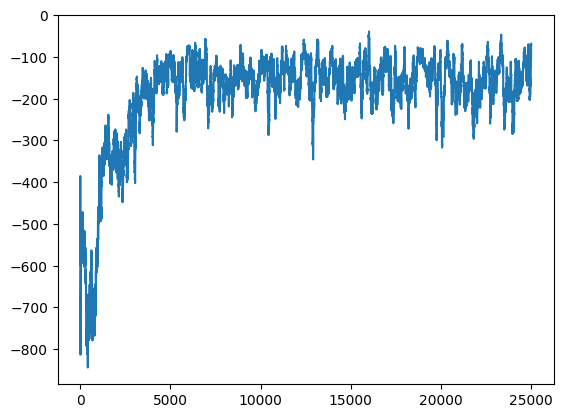

In [23]:
plot_rewards(total_rewards)